In [2]:
from os import path
if not path.exists('utils.py'): # If running on colab: the first time download and unzip additional files
    !wget https://biolab.csr.unibo.it/samples/fr/files.zip
    !unzip files.zip

In [3]:
import math
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
from utils import *
from ipywidgets import interact

# Step 1: Fingerprint segmentation

First of all we load a fingerprint image: it will be stored in memory as a NumPy array.

,,
,,

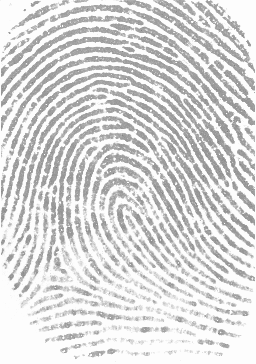
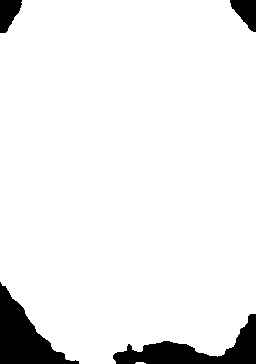
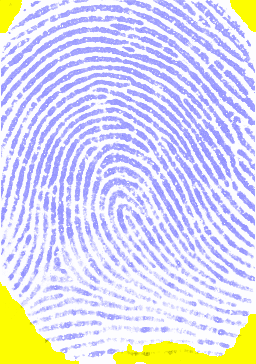

In [50]:
# First of all we load a fingerprint image: it will be stored in memory as a NumPy array.
fingerprint = cv.imread('samples/sample_1_1.png', cv.IMREAD_GRAYSCALE)

# Calculate the local gradient (using Sobel filters)
gx, gy = cv.Sobel(fingerprint, cv.CV_32F, 1, 0), cv.Sobel(fingerprint, cv.CV_32F, 0, 1)

# Calculate the magnitude of the gradient for each pixel
gx2, gy2 = gx**2, gy**2
gm = np.sqrt(gx2 + gy2)

# Integral over a square window
sum_gm = cv.boxFilter(gm, -1, (25, 25), normalize = False)

# Use a simple threshold for segmenting the fingerprint pattern
thr = sum_gm.max() * 0.2
mask = cv.threshold(sum_gm, thr, 255, cv.THRESH_BINARY)[1].astype(np.uint8)

show(fingerprint, mask, cv.merge((mask, fingerprint, fingerprint)))

# Step 2: Estimation of local ridge orientation

The local ridge orientation at $(j,i)$ is the angle $\theta_{j,i}\in[0,180°[$ that the fingerprint ridges form with the horizontal axis in an arbitrary small neighborhood centered in $(j,i)$.  
For each pixel, we will estimate the local orientation from the gradient $[Gx,Gy]$, which we already computed in the segmentation step (see *A.M. Bazen and S.H. Gerez, "Systematic methods for the computation of the directional fields and singular points of fingerprints," in IEEE tPAMI, July 2002*).  

The ridge orientation is estimated as ortoghonal to the gradient orientation, averaged over a window $W$.  

$G_{xx}=\sum_W{G_x^2}$, $G_{yy}=\sum_W{G_y^2}$, $G_{xy}=\sum_W{G_xG_y}$

$\theta=\frac{\pi}{2} + \frac{phase(G_{xx}-G_{yy}, 2G_{xy})}{2}$

For each orientation, we will also calculate a confidence value (strength), which measures how much all gradients in $W$ share the same orientation.  

$strength = \frac{\sqrt{(G_{xx}-G_{yy})^2+(2G_{xy})^2}}{G_{xx}+G_{yy}}$

Orientation image
""

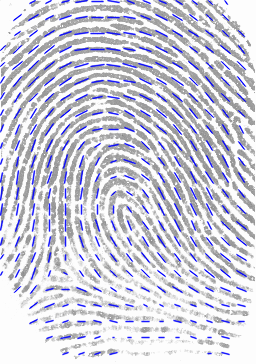

In [51]:
W = (23, 23)
gxx = cv.boxFilter(gx2, -1, W, normalize = False)
gyy = cv.boxFilter(gy2, -1, W, normalize = False)
gxy = cv.boxFilter(gx * gy, -1, W, normalize = False)
gxx_gyy = gxx - gyy
gxy2 = 2 * gxy

orientations = (cv.phase(gxx_gyy, -gxy2) + np.pi) / 2 # '-' to adjust for y axis direction
sum_gxx_gyy = gxx + gyy
# For each orientation, we will also calculate a confidence value (strength), which measures how much all gradients in $W$ share the same orientation.  
strengths = np.divide(cv.sqrt((gxx_gyy**2 + gxy2**2)), sum_gxx_gyy, out=np.zeros_like(gxx), where=sum_gxx_gyy!=0)
show(draw_orientations(fingerprint, orientations, strengths, mask, 1, 16), 'Orientation image')

# Step 3: Estimation of local ridge frequency

The local ridge frequency $f_{j,i}$ at $(j,i)$ is the number of ridges per unit length along a hypothetical segment centered in $(j,i)$ and orthogonal to the local ridge orientation $\theta_{j,i}$.

For simplicity, we will assume a constant frequency over all the fingerprint and estimate its reciprocal (the ridge-line period) from a small region of the image.

""
""

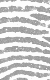

In [10]:
region = fingerprint[10:90,80:130]
show(region)

Then the *x-signature* is computed from the region and the ridge-line period is estimated as the average number of pixels between two consecutive peaks (see *L. Hong, Y. Wan and A. Jain, "Fingerprint image enhancement: algorithm and performance evaluation," in IEEE tPAMI, Aug. 1998*)

In [11]:
# before computing the x-signature, the region is smoothed to reduce noise
smoothed = cv.blur(region, (5,5), -1)
xs = np.sum(smoothed, 1) # the x-signature of the region
print(xs)

[10697 10796 11245 11970 12058 11508 10815 10064  9314  9125  9707 10389
 10912 11370 11564 11116 10419  9916  9532  9250  9370  9833 10348 10899
 11430 11429 11180 10773 10152  9409  9243  9351  9847 10620 11430 11482
 11147 10536  9791  9010  8966  9337  9845 10431 10986 11071 10877 10416
  9732  9264  9514  9946 10642 11353 11533 11050 10398  9649  9345  9636
 10183 10614 10849 10646 10197  9827  9762  9908 10237 10529 10628 10437
 10203 10011 10108 10364 10658 10828 10986 11106]


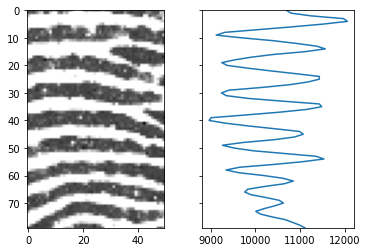

In [52]:
x = np.arange(region.shape[0])
f, axarr = plt.subplots(1,2, sharey = True)
axarr[0].imshow(region,cmap='gray')
axarr[1].plot(xs, x)
axarr[1].set_ylim(region.shape[0]-1,0)
plt.show()

In [53]:
# Find the indices of the x-signature local maxima
local_maxima = np.nonzero(np.r_[False, xs[1:] > xs[:-1]] & np.r_[xs[:-1] >= xs[1:], False])[0]

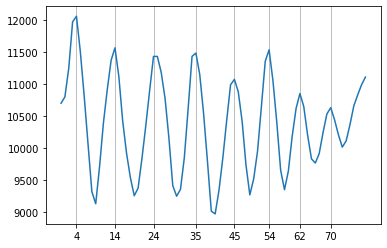

In [14]:
x = np.arange(region.shape[0])
plt.plot(x, xs)
plt.xticks(local_maxima)
plt.grid(True, axis='x')
plt.show()

In [15]:
# Calculate all the distances between consecutive peaks
distances = local_maxima[1:] - local_maxima[:-1]
print(distances)

[10 10 11 10  9  8  8]


In [54]:
# Estimate the ridge line period as the average of the above distances
ridge_period = np.average(distances)
print(ridge_period)

9.428571428571429


# Step 4: Fingerprint enhancement

In order to enhance the fingerprint pattern, we will perform a *contextual convolution* with a bank of Gabor filters.  
In this simple example we are using a constant ridge-line frequency, hence all the filters will have the same period and the only parameter will be the number of orientations (or_count).  
As it is a contextual convolution, a different filter should be applied to each pixel, according to the corresponding ridge-line orientation. Unfortunately this kind of operation is not available in OpenCV and implementing it in Python would be very inefficient; hence, we will apply all the filters to the whole image (that is, producing a filtered image for each filter) and then we will assemble the enhanced image taking the right pixel from each filtered image, using the discretized orientation indices as a lookup table.

In [17]:
# Create the filter bank
or_count = 8
gabor_bank = [gabor_kernel(ridge_period, o) for o in np.arange(0, np.pi, np.pi/or_count)]

,,,,,,,
,,,,,,,

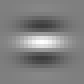
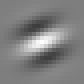
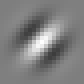
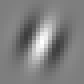
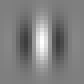
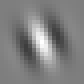
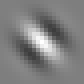
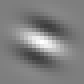

In [18]:
show(*gabor_bank)

,,,,,,,,
,,,,,,,,

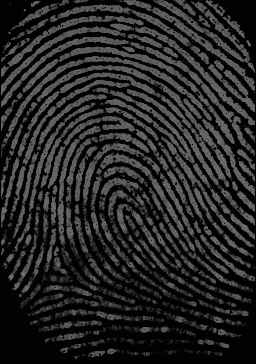
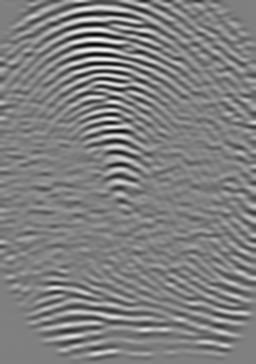
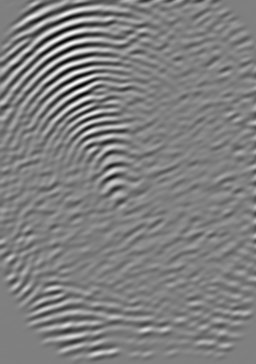
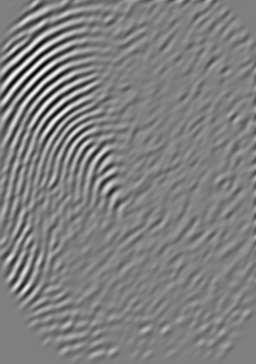
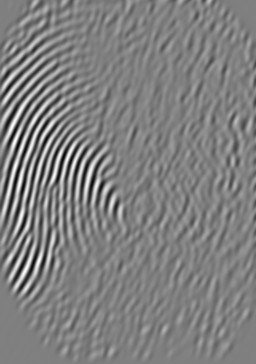
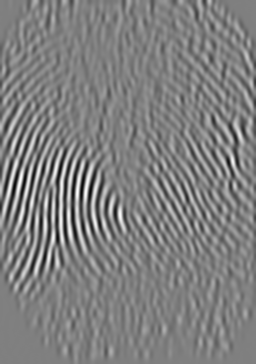
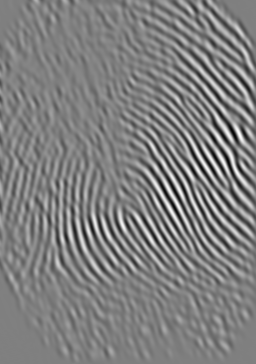
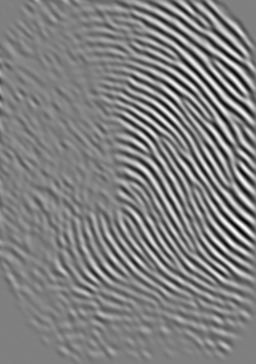
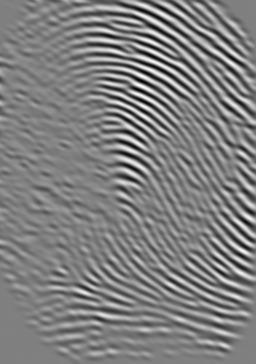

In [19]:
# Filter the whole image with each filter
# Note that the negative image is actually used, to have white ridges on a black background as a result
nf = 255-fingerprint
all_filtered = np.array([cv.filter2D(nf, cv.CV_32F, f) for f in gabor_bank])
show(nf, *all_filtered)

,
,

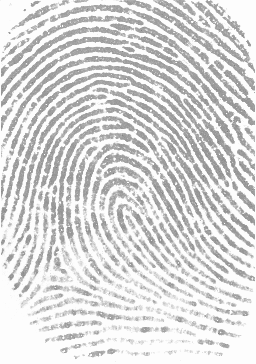
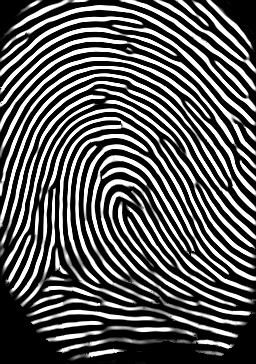

In [20]:
y_coords, x_coords = np.indices(fingerprint.shape)
# For each pixel, find the index of the closest orientation in the gabor bank
orientation_idx = np.round(((orientations % np.pi) / np.pi) * or_count).astype(np.int32) % or_count
# Take the corresponding convolution result for each pixel, to assemble the final result
filtered = all_filtered[orientation_idx, y_coords, x_coords]
# Convert to gray scale and apply the mask
enhanced = mask & np.clip(filtered, 0, 255).astype(np.uint8)
show(fingerprint, enhanced)

# Step 5: Detection of minutiae positions

In this simple example, minutiae will be detected from the *ridge line skeleton*, obtained by binarizing and thinning the enhanced ridge lines.

,,
,,

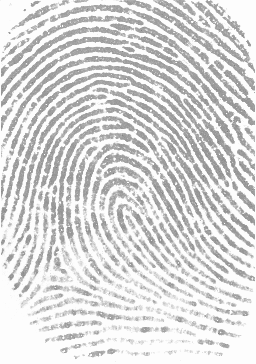
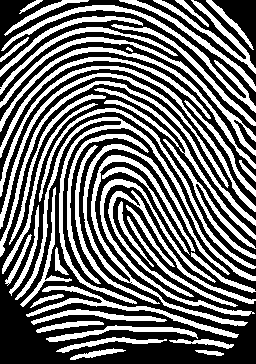
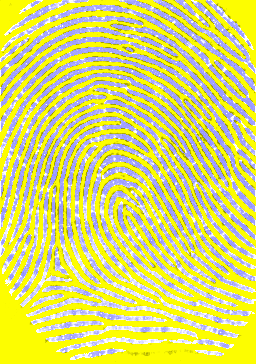

In [21]:
# Binarization
_, ridge_lines = cv.threshold(enhanced, 32, 255, cv.THRESH_BINARY)
show(fingerprint, ridge_lines, cv.merge((ridge_lines, fingerprint, fingerprint)))

,
,

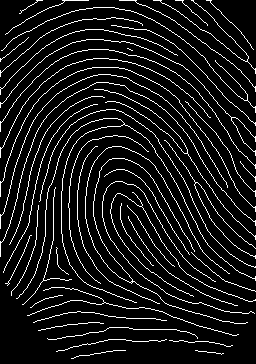
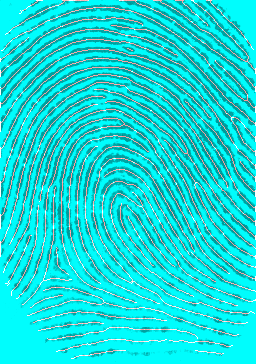

In [22]:
# Thinning
skeleton = cv.ximgproc.thinning(ridge_lines, thinningType = cv.ximgproc.THINNING_GUOHALL)
show(skeleton, cv.merge((fingerprint, fingerprint, skeleton)))

Then, for each pixel $p$ of the skeleton, the *crossing number* $cn(p)$ is computed as the number of transitions from black to white pixels in its 8-neighborhood

```
   v[0] v[1] v[2]
   v[7]   p  v[3]
   v[6] v[5] v[4]
```
$cn(v)=\sum_{i=0}^7\begin{cases} 1 & \mbox{if } v[i]<v[(i+1) \mod 8] \\ 0 & \mbox{otherwise} \end{cases}$

In [23]:
def compute_crossing_number(values):
    return np.count_nonzero(values < np.roll(values, -1))

To efficiently compute all the crossing numbers, a 3x3 filter is used to convert each possible 8-neighborhood into a byte value (by considering each pixel as a bit).  
Then a lookup table maps each byte value [0,255] into the corresponding crossing number.

In [24]:
# Create a filter that converts any 8-neighborhood into the corresponding byte value [0,255]
cn_filter = np.array([[  1,  2,  4],
                      [128,  0,  8],
                      [ 64, 32, 16]
                     ])

In [25]:
# Create a lookup table that maps each byte value to the corresponding crossing number
all_8_neighborhoods = [np.array([int(d) for d in f'{x:08b}'])[::-1] for x in range(256)]
cn_lut = np.array([compute_crossing_number(x) for x in all_8_neighborhoods]).astype(np.uint8)

In [26]:
# Skeleton: from 0/255 to 0/1 values
skeleton01 = np.where(skeleton!=0, 1, 0).astype(np.uint8)
# Apply the filter to encode the 8-neighborhood of each pixel into a byte [0,255]
cn_values = cv.filter2D(skeleton01, -1, cn_filter, borderType = cv.BORDER_CONSTANT)
# Apply the lookup table to obtain the crossing number of each pixel
cn = cv.LUT(cn_values, cn_lut)
# Keep only crossing numbers on the skeleton
cn[skeleton==0] = 0

The list of minutiae is finally obtained from the coordinates of pixels with crossing number 1 (terminations) or 3 (bifurcations).  
Each minutia is stored as a tuple $(x, y, t)$ where $t$ is $true$ for terminations.  
Note that, for now, we are not computing the minutiae *direction*, but only their location and type.

In [27]:
# crossing number == 1 --> Termination, crossing number == 3 --> Bifurcation
minutiae = [(x,y,cn[y,x]==1) for y, x in zip(*np.where(np.isin(cn, [1,3])))]

,,
,,

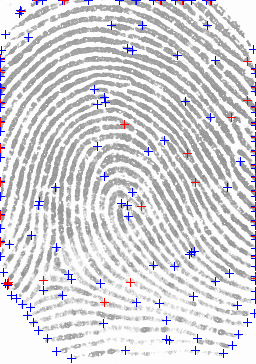
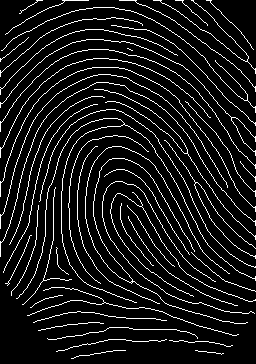
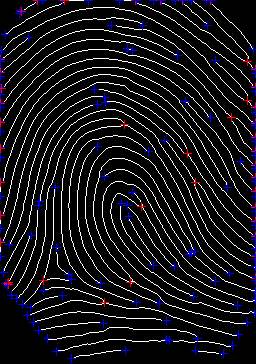

In [28]:
show(draw_minutiae(fingerprint, minutiae), skeleton, draw_minutiae(skeleton, minutiae))

From the above image we can note that near the borders of the pattern many false minutiae are detected: we can remove them by computing the *distance transform* of the segmentation mask and choosing a threshold so that minutiae too close to the mask border are excluded.

,
,

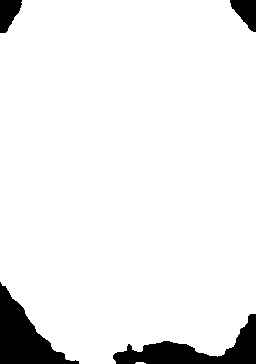
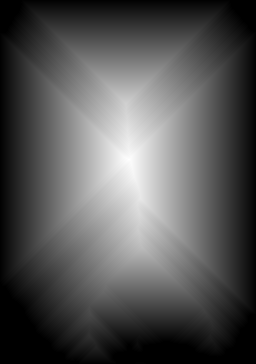

In [29]:
# A 1-pixel background border is added to the mask before computing the distance transform
mask_distance = cv.distanceTransform(cv.copyMakeBorder(mask, 1, 1, 1, 1, cv.BORDER_CONSTANT), cv.DIST_C, 3)[1:-1,1:-1]
show(mask, mask_distance)

In [30]:
filtered_minutiae = list(filter(lambda m: mask_distance[m[1], m[0]]>10, minutiae))

,,
,,

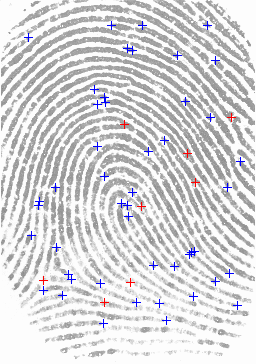
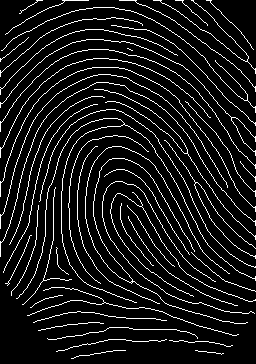
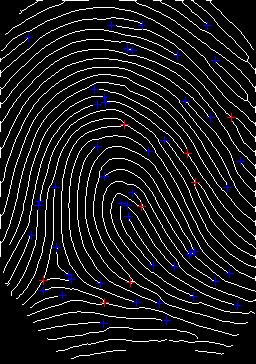

In [31]:
show(draw_minutiae(fingerprint, filtered_minutiae), skeleton, draw_minutiae(skeleton, filtered_minutiae))

# Step 6: Estimation of minutiae directions

The direction of a termination will be computed by following the ridge-line until another minutia is found or a distance of 20 pixels has been traveled.  
The direction of a bifurcation will be computed by considering the directions ($\theta_1$, $\theta_2$, $\theta_3$) of its three branches and calculating the mean of the two closest ones ($\theta_1$ and $\theta_2$ in the example below).  
Note that this is a simplified definition of minutiae direction, not completely consistent to the ISO standard minutiae-based template format, which is based on ridge and valley skeletons (see *ISO/IEC 19794-2, 2005*).

<img src="https://biolab.csr.unibo.it/samples/fr/images/min_directions.png">

In order to follow the ridge-line, for each position on the skeleton, the position of the next pixel to be visited must be determined. In the following, the eight possible direction of movement will be encoded as integer numbers in [0,7], following the same ordering previously used for the 8-neighborhood of a pixel $p$:

```
   0  1  2
   7  p  3
   6  5  4
```

The following function, given the previous direction of movement and the values of the 8 neighboring pixels, returns the  directions towards neighboring skeleton pixels, excluding the previously-visited one. A special value (8) indicates that there is no previous direction: it will be used at the first step.

In [32]:
def compute_next_ridge_following_directions(previous_direction, values):    
    next_positions = np.argwhere(values!=0).ravel().tolist()
    if len(next_positions) > 0 and previous_direction != 8:
        # There is a previous direction: return all the next directions, sorted according to the distance from it,
        #                                except the direction, if any, that corresponds to the previous position
        next_positions.sort(key = lambda d: 4 - abs(abs(d - previous_direction) - 4))
        if next_positions[-1] == (previous_direction + 4) % 8: # the direction of the previous position is the opposite one
            next_positions = next_positions[:-1] # removes it
    return next_positions

It is always a good idea to avoid unnecessary computations: the next cell prepares two look-up tables.

In [33]:
r2 = 2**0.5 # sqrt(2)

# The eight possible (x, y) offsets with each corresponding Euclidean distance
xy_steps = [(-1,-1,r2),( 0,-1,1),( 1,-1,r2),( 1, 0,1),( 1, 1,r2),( 0, 1,1),(-1, 1,r2),(-1, 0,1)]

# LUT: for each 8-neighborhood and each previous direction [0,8], 
#      where 8 means "none", provides the list of possible directions
nd_lut = [[compute_next_ridge_following_directions(pd, x) for pd in range(9)] for x in all_8_neighborhoods]

The next function follows the skeleton until another minutia is found or a distance of 20 pixels has been traveled. If a minimum length of 10 pixels has been reached, it returns the corresponding angle, otherwise it returns None.

In [34]:
def follow_ridge_and_compute_angle(x, y, d = 8):
    px, py = x, y
    length = 0.0
    while length < 20: # max length followed
        next_directions = nd_lut[cn_values[py,px]][d]
        if len(next_directions) == 0:
            break
        # Need to check ALL possible next directions
        if (any(cn[py + xy_steps[nd][1], px + xy_steps[nd][0]] != 2 for nd in next_directions)):
            break # another minutia found: we stop here
        # Only the first direction has to be followed
        d = next_directions[0]
        ox, oy, l = xy_steps[d]
        px += ox ; py += oy ; length += l
    # check if the minimum length for a valid direction has been reached
    return math.atan2(-py+y, px-x) if length >= 10 else None

Finally, the cell below estimates all minutiae directions:
- in case of a termination, it simply calls the previous function,
- in case of a bifurcation, it follows the three branches and if all the three angles are valid, it computes the mean of the two closest ones.

The list of minutiae is finally obtained, with each minutia stored as a tuple $(x, y, t, d)$ where $t$ is $true$ for terminations and $d$ is the minutia direction in radians.

In [35]:
valid_minutiae = []
for x, y, term in filtered_minutiae:
    d = None
    if term: # termination: simply follow and compute the direction        
        d = follow_ridge_and_compute_angle(x, y)
    else: # bifurcation: follow each of the three branches
        dirs = nd_lut[cn_values[y,x]][8] # 8 means: no previous direction
        if len(dirs)==3: # only if there are exactly three branches
            angles = [follow_ridge_and_compute_angle(x+xy_steps[d][0], y+xy_steps[d][1], d) for d in dirs]
            if all(a is not None for a in angles):
                a1, a2 = min(((angles[i], angles[(i+1)%3]) for i in range(3)), key=lambda t: angle_abs_difference(t[0], t[1]))
                d = angle_mean(a1, a2)                
    if d is not None:
        valid_minutiae.append( (x, y, term, d) )

""
""

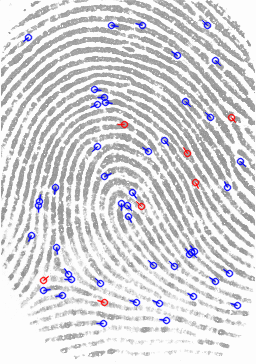

In [36]:
show(draw_minutiae(fingerprint, valid_minutiae))